# Notebook para probar un modelo Deep Learning Bert

In [ ]:
!pip install --upgrade pip
!pip uninstall tensorflow
!pip install tensorflow
!pip install tensorflow_text
import tensorflow_text as texty


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 14.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Nov 21 09:16:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Cargamos el dataset y lo dividimos en insinceras y sinceras para poderlo equilibrar posteriormente

In [ ]:
import pandas as pd
import re
#Cargo el dataset de ejemplo
total_questionsdf = pd.read_csv('train.csv')

print (total_questionsdf.shape)

insincere_questionsdf=total_questionsdf.loc[total_questionsdf['target'] == 1]

print (insincere_questionsdf.shape)
total_questionsdf.head()

sincere_questionsdf=total_questionsdf.loc[total_questionsdf['target'] == 0].sample(len(insincere_questionsdf))
print (sincere_questionsdf.shape)

(1223871, 3)
(75730, 3)
(75730, 3)


Tomamos una muestra equilibrada del conjunto total, pasamos a minúsculas y eliminamos símbolos extraños

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn import metrics
#Vamos a separar los conjuntos de entrenamiento en conjuntos más proporcionados, donde tengamos la mitad de opiniones sinceras y la mitad de insinceras y veamos qué sucede
from nltk import pos_tag, word_tokenize
muestraInsinceras=insincere_questionsdf.sample(40000)
muestraSinceras=sincere_questionsdf.sample(40000)

questions=muestraInsinceras['question_text'].append(muestraSinceras['question_text']).tolist()
tags = muestraInsinceras['target'].append(muestraSinceras['target']).tolist()

data = []
data_labels = []

for i in range(len(questions)): 
    questions[i]=questions[i].lower()
    questions[i]=re.sub('[^a-zA-Z\']', ' ', questions[i])
    data.append(questions[i]) 
    data_labels.append(tags[i])
X_train, X_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.2, random_state=12) 



Definimos las capas de preprocesamiento y encoding BERT

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text
bert_preprocess_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Generamos el modelo y lo representamos gráficamente

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


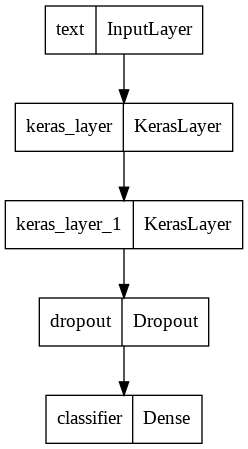

In [ ]:
#############################################
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector

# La siguiente función define el modelo.

def build_classifier_model_Bert():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = bert_preprocess_layer(text_input)
  outputs = bert_encoder_layer(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

mt_model_Bert = build_classifier_model_Bert()

tf.keras.utils.plot_model(mt_model_Bert)


Se utiliza el optimizador Adam

In [ ]:
from tensorflow import optimizers

rms = optimizers.Adam(learning_rate=0.001)
mt_model_Bert.compile(optimizer=rms, loss='binary_crossentropy')

Entrenamos el modelo y lo guardamos en un fichero

In [ ]:

from keras.callbacks import ModelCheckpoint
filename = 'model_clasif_Bert' #Fichero donde guardaremos el modelo para hacer las posteriores predicciones

#La función ModelCheckpoint() guarda el modelo 

checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=False, mode='min')

#Entrenamiento del modelo. Se realiza con 30 epoch con un tamaño de batch de 512
mt_model_Bert.fit(X_train, y_train, epochs=25, batch_size=512, callbacks=[checkpoint], verbose=1)



Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 0.6025 
Epoch 1: saving model to model_clasif_Bert


125/125 [==============================] - 1394s 11s/step - loss: 0.6025
Epoch 2/25
125/125 [==============================] - ETA: 0s - loss: 0.5169 
Epoch 2: saving model to model_clasif_Bert


125/125 [==============================] - 1399s 11s/step - loss: 0.5169
Epoch 3/25
125/125 [==============================] - ETA: 0s - loss: 0.4757 
Epoch 3: saving model to model_clasif_Bert


125/125 [==============================] - 1394s 11s/step - loss: 0.4757
Epoch 4/25
125/125 [==============================] - ETA: 0s - loss: 0.4489 
Epoch 4: saving model to model_clasif_Bert


125/125 [==============================] - 1395s 11s/step - loss: 0.4489
Epoch 5/25
125/125 [==============================] - ETA: 0s - loss: 0.4325 
Epoch 5: saving model to model_clasif_Bert


125/125 [==============================] - 1394s 11s/step - loss: 0.4325
Epoch 6/25
125/125 [==============================] - ETA: 0s - loss: 0.4212 
Epoch 6: saving model to model_clasif_Bert


125/125 [==============================] - 1392s 11s/step - loss: 0.4212
Epoch 7/25
125/125 [==============================] - ETA: 0s - loss: 0.4115 
Epoch 7: saving model to model_clasif_Bert


125/125 [==============================] - 1389s 11s/step - loss: 0.4115
Epoch 8/25
125/125 [==============================] - ETA: 0s - loss: 0.4048 
Epoch 8: saving model to model_clasif_Bert


125/125 [==============================] - 1395s 11s/step - loss: 0.4048
Epoch 9/25
125/125 [==============================] - ETA: 0s - loss: 0.3998 
Epoch 9: saving model to model_clasif_Bert


125/125 [==============================] - 1389s 11s/step - loss: 0.3998
Epoch 10/25
125/125 [==============================] - ETA: 0s - loss: 0.3967 
Epoch 10: saving model to model_clasif_Bert


125/125 [==============================] - 1390s 11s/step - loss: 0.3967
Epoch 11/25
125/125 [==============================] - ETA: 0s - loss: 0.3931 
Epoch 11: saving model to model_clasif_Bert


125/125 [==============================] - 1390s 11s/step - loss: 0.3931
Epoch 12/25
125/125 [==============================] - ETA: 0s - loss: 0.3907 
Epoch 12: saving model to model_clasif_Bert


125/125 [==============================] - 1385s 11s/step - loss: 0.3907
Epoch 13/25
125/125 [==============================] - ETA: 0s - loss: 0.3882 
Epoch 13: saving model to model_clasif_Bert


125/125 [==============================] - 1391s 11s/step - loss: 0.3882
Epoch 14/25
125/125 [==============================] - ETA: 0s - loss: 0.3853 
Epoch 14: saving model to model_clasif_Bert


125/125 [==============================] - 1383s 11s/step - loss: 0.3853
Epoch 15/25
125/125 [==============================] - ETA: 0s - loss: 0.3835 
Epoch 15: saving model to model_clasif_Bert


125/125 [==============================] - 1386s 11s/step - loss: 0.3835
Epoch 16/25
125/125 [==============================] - ETA: 0s - loss: 0.3818 
Epoch 16: saving model to model_clasif_Bert


125/125 [==============================] - 1393s 11s/step - loss: 0.3818
Epoch 17/25
125/125 [==============================] - ETA: 0s - loss: 0.3821 
Epoch 17: saving model to model_clasif_Bert


125/125 [==============================] - 1389s 11s/step - loss: 0.3821
Epoch 18/25
125/125 [==============================] - ETA: 0s - loss: 0.3799 
Epoch 18: saving model to model_clasif_Bert


125/125 [==============================] - 1388s 11s/step - loss: 0.3799
Epoch 19/25
125/125 [==============================] - ETA: 0s - loss: 0.3786 
Epoch 19: saving model to model_clasif_Bert


125/125 [==============================] - 1390s 11s/step - loss: 0.3786
Epoch 20/25
125/125 [==============================] - ETA: 0s - loss: 0.3773 
Epoch 20: saving model to model_clasif_Bert


125/125 [==============================] - 1388s 11s/step - loss: 0.3773
Epoch 21/25
125/125 [==============================] - ETA: 0s - loss: 0.3776 
Epoch 21: saving model to model_clasif_Bert


125/125 [==============================] - 1389s 11s/step - loss: 0.3776
Epoch 22/25
125/125 [==============================] - ETA: 0s - loss: 0.3780 
Epoch 22: saving model to model_clasif_Bert


125/125 [==============================] - 1393s 11s/step - loss: 0.3780
Epoch 23/25
125/125 [==============================] - ETA: 0s - loss: 0.3747 
Epoch 23: saving model to model_clasif_Bert


125/125 [==============================] - 1392s 11s/step - loss: 0.3747
Epoch 24/25
125/125 [==============================] - ETA: 0s - loss: 0.3746 
Epoch 24: saving model to model_clasif_Bert


125/125 [==============================] - 1394s 11s/step - loss: 0.3746
Epoch 25/25
125/125 [==============================] - ETA: 0s - loss: 0.3747 
Epoch 25: saving model to model_clasif_Bert


125/125 [==============================] - 1396s 11s/step - loss: 0.3747


Cargamos el modelo

In [ ]:
from keras.models import load_model

#Cargo el modelo y realizo las predicciones
modelClasificador = load_model('model_clasif_Bert')
preds = modelClasificador.predict(X_test)


500/500 [==============================] - 164s 326ms/step


Transformamos las predicciones en función de su valor (SINCERAS las que tienen valor inferior a 0.5 y sinceras el resto)

In [ ]:
import numpy as np
y_predicted = preds.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)


Comprobamos los resultados

In [ ]:
from sklearn.metrics import accuracy_score
#Calculo el porcentaje de aciertos ayudándome de accuracy_score de sklearn

resultado=accuracy_score(y_test, y_predicted)
print("El porcentaje de acierto en la clasificación es ", resultado)
rm = metrics.classification_report(y_test, y_predicted, target_names=['SINCERE', 'INSINCERE'])

print(rm)

El porcentaje de acierto en la clasificación es  0.855125
              precision    recall  f1-score   support

     SINCERE       0.85      0.87      0.86      8072
   INSINCERE       0.86      0.84      0.85      7928

    accuracy                           0.86     16000
   macro avg       0.86      0.86      0.86     16000
weighted avg       0.86      0.86      0.86     16000



In [ ]:
%%shell
jupyter nbconvert --to html /content/TFM_4_LSMT.ipynb